

---


packages
---



---



In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import csv
import requests
import json
import re
import os
import seaborn as sns
import string
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True



---
web scrapping, dataset creation

---




In [ ]:
def get_blog_url(soup):
  div = soup.find_all('div',attrs = {'class':'FL PR20'})
  url_list =[]
  for title in div:
    href = title.find('a')['href']
    url_list.append("https://www.moneycontrol.com/"+href)
  return url_list

In [ ]:
def get_blog_content(url):
  request = requests.get(url)
  soupurl = BeautifulSoup(request.text,'html.parser')
  all_script = soupurl.find_all('script',attrs ={'type': 'application/ld+json'})
  raw_article_str = all_script[2].get_text().replace('\r\n',' ')
  parts = re.split(r"""("[^"]*"|'[^']*')""",raw_article_str)
  parts[::2] = map(lambda s:"".join(s.split()),parts[::2])
  article_str = "".join(parts)
  article_str = article_str[1:]
  article_str = article_str[:-1]
  article_dict = json.loads(article_str)
  all_tags = soupurl.find_all('div',attrs = {'class':'tags_first_line'})
  lst_all_tags = []
  for i in all_tags:
    lst_all_tags.append(i.get_text())
  tags = lst_all_tags[0].replace('Tags:','')
  tags = tags.replace('\n','')
  tags = tags.split("#")
  tags = tags[1:]
  tags = ','.join([str(elem).strip() for elem in tags])
  article_dict['tags'] = tags

  return article_dict

In [ ]:
def get_page_no(url,sc_id,page_no,next,year):
  request = requests.get(url)
  soup = BeautifulSoup(request.text,'html.parser')
  all_page_no = soup.find_all('div',attrs = {'class':'pages MR10 MT15'})
  page_list = [i.text for i in all_page_no[0].find_all('a')]
  if any(map(str.isdigit,page_list[-1])):
    return int(page_list[-1]),next
  else:
    next = next + 1
    page_no = int(page_list[-2])
    url = "https://www.moneycontrol.com/stocks/company_info/stocks_news.php?sc_id="+sc_id+"&scat=&pageno="+str(page_no)+"&next="+str(next)+"&durationType=Y&Year="+str(year)+"&duration=1&news_type="
    return get_page_no(url,sc_id,page_no,next,year)

In [ ]:
def save_company_data(url_ = "https://www.moneycontrol.com/stocks/company_info/stock_news.php?",sc_id=[],page_no=1,next=0,years=[]):
  for company in sc_id:
    df = pd.DataFrame(columns=['company','datePublished',
                               'headline',
                               'description','articleBody',
                               'tags','url'])

    for year in years:
      print('year: ',year)
      print('page no: ',page_no)
      print('next: ',next)

      url = url_+"sc_id="+company+"&scat=&pageno="+str(page_no)+"&next="+str(next)+"&durationType=Y&Year="+str(year)+"&duration=1&news_type="
      print(url)

      max_page_no,max_next = get_page_no(url,company,page_no,next,year)
      max_next = max_next+1

      for i in range(max_next):
        for j in range((i*10)+1,(i*10)+11):
          if j<=max_page_no:
            url_list=[]
            url = url_+"sc_id="+company+"&scat=&pageno="+str(j)+"&next="+str(i)+"&durationType=Y&Year="+str(year)+"&duration=1&news_type="
            request = requests.get(url)
            soup = BeautifulSoup(request.text,'html.parser')
            url_list = get_blog_url(soup)

            for url in url_list:
              try:
                article_dict1 = get_blog_content(url)
                print(company)
                print(article_dict1['datePublished'])
                print(article_dict1['url'])
                print("--------------------------------------------------")

                article_list=[[company,
                              article_dict1['datePublished'],article_dict1['headline'],
                              article_dict1['description'],article_dict1['articleBody'],
                              article_dict1['tags'],
                              url]]
                print(article_list)
                dataFrame = pd.DataFrame(article_list,columns=['company','datePublished','headline',
                                                                  'description','articleBody','tags','url']);
                df = pd.concat([df, dataFrame], ignore_index = True)
              except:
                article_list = [[company,'error','error','error','error','error',url]]
                print(article_list)
                dataFrame = pd.DataFrame(article_list,columns=['company','datePublished','headline','description','articleBody','tags','url'])
                df = pd.concat([df, dataFrame], ignore_index = True)

                continue
          else:
            break
      df.to_csv('/content/'+company+'.csv')

In [ ]:
# @title all company data
# def save_company_data(url_ = "https://www.moneycontrol.com/stocks/company_info/stock_news.php?",sc_id=[],page_no=1,next=0,years=[]):
#   all_data = []
#   for company in sc_id:
#     df = pd.DataFrame(columns=['company','datePublished',
#                                'headline',
#                                'description','articleBody',
#                                'tags','url'])

#     for year in years:
#       print('year: ',year)
#       print('page no: ',page_no)
#       print('next: ',next)

#       url = url_+"sc_id="+company+"&scat=&pageno="+str(page_no)+"&next="+str(next)+"&durationType=Y&Year="+str(year)+"&duration=1&news_type="
#       print(url)

#       max_page_no,max_next = get_page_no(url,company,page_no,next,year)
#       max_next = max_next+1

#       for i in range(max_next):
#         for j in range((i*10)+1,(i*10)+11):
#           if j<=max_page_no:
#             url_list=[]
#             url = url_+"sc_id="+company+"&scat=&pageno="+str(j)+"&next="+str(i)+"&durationType=Y&Year="+str(year)+"&duration=1&news_type="
#             request = requests.get(url)
#             soup = BeautifulSoup(request.text,'html.parser')
#             url_list = get_blog_url(soup)

#             for url in url_list:
#               try:
#                 article_dict1 = get_blog_content(url)
#                 print(company)
#                 print(article_dict1['datePublished'])
#                 print(article_dict1['url'])
#                 print("--------------------------------------------------")

#                 article_list=[company,
#                               article_dict1['datePublished'],article_dict1['headline'],
#                               article_dict1['description'],article_dict1['articleBody'],
#                               article_dict1['tags'],
#                               url]
#                 print(article_list)
#                 all_data.append(article_list)

#               except:
#                 article_list = [company,'error','error','error','error','error',url]
#                 print(article_list)
#                 all_data.append(article_list)


#                 continue
#           else:
#             break
#       all_data.extend(df.values.tolist())



    # Create a single DataFrame from all the data
    # combined_df = pd.DataFrame(all_data, columns=['company', 'datePublished', 'headline', 'description', 'articleBody', 'tags', 'url'])

    # # Save the combined DataFrame to a single CSV file
    # combined_df.to_csv('/content/all_companies.csv', mode='a', header=False, index=False)
    #   df = pd.DataFrame(all_data, columns=['company', 'datePublished', 'headline', 'description', 'articleBody', 'tags', 'url'])

    # # Save the DataFrame to a single CSV file
    #   df.to_csv('/content/all_companies.csv')


In [ ]:
# @title web scrapping news

l = ['TEL','LI09','IT','HDF01','RI']
for i in l:
  save_company_data(sc_id=[i],years =[2023,2022,2021])

In [ ]:
# @title time series
import yfinance as yf
# Define the stock symbol and date range
l = ['TATAMOTORS.NS','LTIM.NS','INFY.NS','HDFCBANK.NS','RELIANCE.NS']
f = ['TEL','LI09','IT','HDF01','RI']
stock = pd.DataFrame()

for i in range(len(l)):
  stock_symbol = l[i]
  start_date = "2021-01-01"
  end_date = "2023-11-05"

# Fetch historical data
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
  stock_data['Company'] = f[i]
  stock=stock.append(stock_data)
  stock_data.to_csv(l[i]+'.csv')


In [ ]:
# @title merging
from yfinance.data import time
l = ['TATAMOTORS.NS','LTIM.NS','INFY.NS','HDFCBANK.NS','RELIANCE.NS']
f = ['TEL','LI09','IT','HDF01','RI']
for i in range(len(f)):
  newspath= '/content/'+f[i]+'.csv'
  timeseriespath = '/content/'+l[i]+'.csv'
  df1 = pd.read_csv(newspath)
  df2 = pd.read_csv(timeseriespath)
  print(df2)
  print(df1)
  merged_data = pd.merge(df1, df2,on=('Date','Company'))
  # print(merged_data)
  merged_data.to_csv(f[i]+' combined.csv', index=False)




---



---


sentiment analysis


---



In [ ]:
# @title preprocessing
# Load the stock news data from a CSV file
f = ['TEL','LI09','IT','HDF01','RI']
for i in f:

  data = pd.read_csv('/content/'+i+' combined.csv')

  # Specify the name of the column to preprocess
  column_to_preprocess = 'articleBody'

  # Define a function for text preprocessing
  def preprocess_text(text):
      # Convert text to lowercase
      text = text.lower()

      # Remove punctuation
      translator = str.maketrans('', '', string.punctuation)
      text = text.translate(translator)

      # Tokenize the text
      tokens = text.split()

      # Remove stopwords
      stop_words = set(stopwords.words('english'))
      filtered_tokens = [word for word in tokens if word not in stop_words]

      # Lemmatize the tokens
      lemmatizer = WordNetLemmatizer()
      lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

      # Join the tokens back into a single string
      preprocessed_text = ' '.join(lemmatized_tokens)

      return preprocessed_text

  # Apply the preprocessing function to the specified column
  data[column_to_preprocess] = data[column_to_preprocess].apply(preprocess_text)
  # should make new column
  data.to_csv('/content/'+i+' combined.csv')
  # Display the preprocessed data
  print(data[[column_to_preprocess]].head())

  def analyze_sentiment(text):
      analysis = TextBlob(text)
      sentiment = analysis.sentiment.polarity
      if sentiment > 0:
          return 'positive'
      elif sentiment < 0:
          return 'negative'
      else:
          return 'neutral'

  # Apply sentiment analysis to the news data
  data['sentiment'] = data['articleBody'].apply(analyze_sentiment)
  print(data)
  data.to_csv(i+'sentiment.csv',index = False)


                                         articleBody
0  tata motor wednesday reported 589 per cent ris...
1  market expected see nearterm healthy support 1...
2  tata technology ltd reserving portion upcoming...
3  kr chokseys research report tata motor ttmtrsq...
4  motilal oswals research report tata motor tata...
     Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Company        Date  \
0               0             0           0     TEL  01-11-2023   
1               1             1           1     TEL  16-10-2023   
2               2             2           2     TEL  04-10-2023   
3               3             3           3     TEL  02-08-2023   
4               4             4           4     TEL  28-07-2023   
..            ...           ...         ...     ...         ...   
196           196           196         196     TEL  15-01-2021   
197           197           197         197     TEL  14-01-2021   
198           198           198         198     TEL  11-01-2021   
199         

In [ ]:

# data = pd.read_csv('/content/all_companies trail.csv')

# # Specify the name of the column to preprocess
# column_to_preprocess = 'Content'

# # Define a function for text preprocessing
# def preprocess_text(text):
#     # Convert text to lowercase
#     text = text.lower()

#     # Remove punctuation
#     translator = str.maketrans('', '', string.punctuation)
#     text = text.translate(translator)

#     # Tokenize the text
#     tokens = text.split()

#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     filtered_tokens = [word for word in tokens if word not in stop_words]

#     # Lemmatize the tokens
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

#     # Join the tokens back into a single string
#     preprocessed_text = ' '.join(lemmatized_tokens)

#     return preprocessed_text

# # Apply the preprocessing function to the specified column
# data[column_to_preprocess] = data[column_to_preprocess].apply(preprocess_text)
# # should make new column
# data.to_csv('/content/all_companies trail.csv')
# # Display the preprocessed data
# print(data[[column_to_preprocess]].head())

# def analyze_sentiment(text):
#     analysis = TextBlob(text)
#     sentiment = analysis.sentiment.polarity
#     if sentiment > 0:
#         return 'positive'
#     elif sentiment < 0:
#         return 'negative'
#     else:
#         return 'neutral'

# # Apply sentiment analysis to the news data
# data['sentiment'] = data['Content'].apply(analyze_sentiment)
# print(data)
# data.to_csv('sentiment.csv',index = False)


In [ ]:
df  =pd.read_csv('sentiment.csv')

In [ ]:
df['sentiment'].value_counts()['positive']

131

In [ ]:
df['sentiment'].value_counts()['neutral']

2

In [ ]:
df['sentiment'].value_counts()['negative']

24

In [ ]:
data = pd.read_csv('/content/TEL combined.csv')
print(data.head())

summary = data.describe()
print("--------\n SUMMARY\n--------\n",summary)


**~~~---------------------------------------------------------------------------------------------------------------------------~~~**

In [ ]:
# Assuming you have a DataFrame 'data' with columns 'text' and 'closing_price'
data['stock_price_change'] = data['Close'].diff().shift(-1)
data

In [ ]:
# from textblob import TextBlob
# f = ['TEL','LI09','IT','HDF01','RI']
# for i in f:
#   def analyze_sentiment(text):
#       analysis = TextBlob(text)
#       sentiment = analysis.sentiment.polarity
#       if sentiment > 0:
#           return 'positive'
#       elif sentiment < 0:
#           return 'negative'
#       else:
#           return 'neutral'

#   # Apply sentiment analysis to the news data
#   data['sentiment'] = data['articleBody'].apply(analyze_sentiment)
#   print(data)
#   data.to_csv(i+'sentiment.csv',index = False)

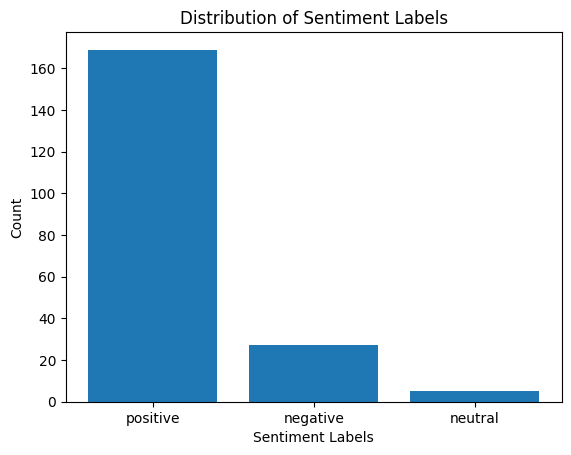

<ipython-input-24-60eab747ca65>:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


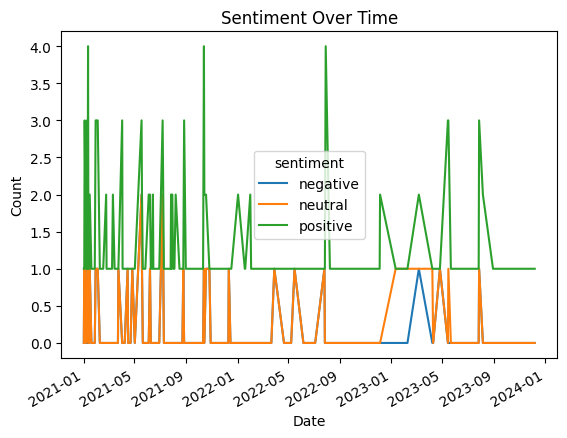

In [ ]:
# @title SENTIMENT GRAPH
sentiment_counts = data['sentiment'].value_counts()

# Visualize the distribution
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

# Assuming you have a 'date' column in your dataset
data['Date'] = pd.to_datetime(data['Date'])

# Group data by date and sentiment
sentiment_over_time = data.groupby(['Date', 'sentiment']).size().unstack().fillna(0)

# Create a time series plot
sentiment_over_time.plot(kind='line', stacked=True)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Over Time')
plt.show()



In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob

# Load the data from a CSV file
data = pd.read_csv('/content/IT combined.csv')

# Define a function for text preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Stem the words
    words = [stemmer.stem(word) for word in words]
    # Join the words back into a cleaned text
    cleaned_text = ' '.join(words)
    return cleaned_text

# Apply the preprocessing function to the news content
data['cleaned_text'] = data['articleBody'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Define a function to analyze sentiment
def analyze_sentiment(text):
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the cleaned text
data['sentiment'] = data['cleaned_text'].apply(analyze_sentiment)

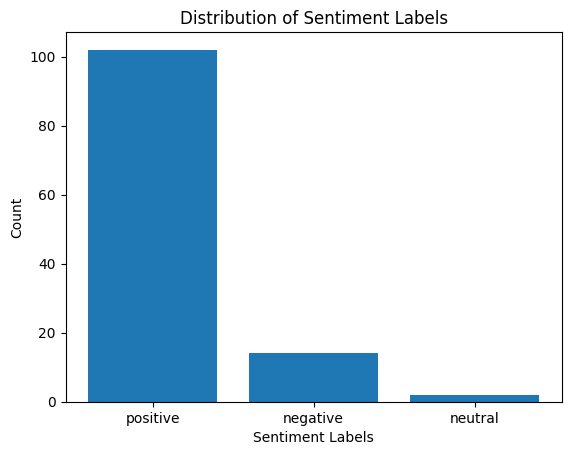

<ipython-input-26-6ac9c2113cc9>:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


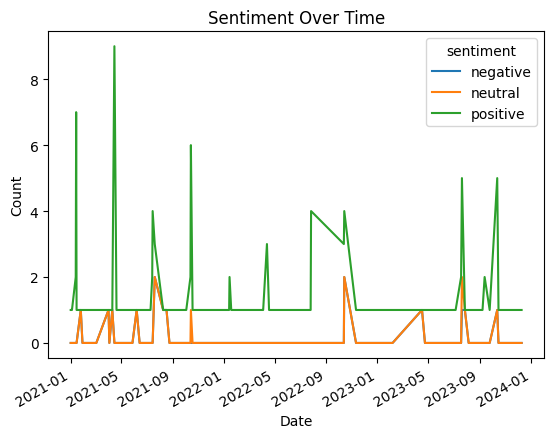

In [ ]:
# @title SENTIMENT GRAPH
sentiment_counts = data['sentiment'].value_counts()

# Visualize the distribution
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

# Assuming you have a 'date' column in your dataset
data['Date'] = pd.to_datetime(data['Date'])

# Group data by date and sentiment
sentiment_over_time = data.groupby(['Date', 'sentiment']).size().unstack().fillna(0)

# Create a time series plot
sentiment_over_time.plot(kind='line', stacked=True)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Over Time')
plt.show()

In [ ]:
data['sentiment'].value_counts()['negative']

14

In [ ]:
data['sentiment'].value_counts()['positive']

102

In [ ]:
data['sentiment'].value_counts()['neutral']

2

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'data' contains the 'cleaned_text' and 'sentiment' columns

# Split the data into training and testing sets
X = data['cleaned_text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create and train the sentiment analysis model
sentiment_classifier = MultinomialNB()
sentiment_classifier.fit(X_train_tfidf, y_train)

# Predict sentiment labels on the test set
y_pred = sentiment_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)


Accuracy: 0.7916666666666666
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
     neutral       0.00      0.00      0.00         1
    positive       0.79      1.00      0.88        19

    accuracy                           0.79        24
   macro avg       0.26      0.33      0.29        24
weighted avg       0.63      0.79      0.70        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# New text data for testing
new_text = ["This is a great product and I love it.",
            "I'm really disappointed with the customer service.",
            "The weather is nice today."]

# Preprocess the new text data (clean and perform the same preprocessing as the training data)
new_text = [preprocess_text(text) for text in new_text]

# Vectorize the preprocessed new data using the same vectorizer
new_text_tfidf = tfidf_vectorizer.transform(new_text)

# Use the trained sentiment analysis model to predict sentiment labels for the new data
predicted_sentiments = sentiment_classifier.predict(new_text_tfidf)

# Display the predicted sentiments for the new text data
for text, sentiment in zip(new_text, predicted_sentiments):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}\n")

Text: great product love .
Predicted Sentiment: positive

Text: 'm realli disappoint custom servic .
Predicted Sentiment: positive

Text: weather nice today .
Predicted Sentiment: positive



In [ ]:
# @title preprocessing and feature engineering
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# nltk.download('punkt')

data = pd.read_csv('')

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Stem the words
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

data['preprocessed_text'] = data['articleBody'].apply(preprocess_text)
data.to_csv('TELsentiment.csv')

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(data['preprocessed_text'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['sentiment'], test_size=0.3)

# Feature Engineering (Example: Word Count)
data['word_count'] = data['preprocessed_text'].apply(lambda x: len(x.split()))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Create a Multinomial Naive Bayes classifier
sentiment_classifier = MultinomialNB()

sentiment_classifier.fit(X_train, y_train)

# Predict sentiment labels on the testing data
y_pred = sentiment_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
    positive       0.90      1.00      0.95        18

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def preprocess_text(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text
text = 'Tata stock is bad. they supposed to decrease it'
preprocessed_text = preprocess_text(text)
new_text_tfidf = tfidf_vectorizer.transform([preprocessed_text])

predicted_sentiment = sentiment_classifier.predict(new_text_tfidf)

print(f"The predicted sentiment is: {predicted_sentiment}")

The predicted sentiment is: ['positive']
